# Fitting

In [3]:
import sys
sys.path.insert(0, '../../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix, IdealSPAM
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio, Spectrum, coat_spectrum, spectrum_to_angular, spectrum_to_radial
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
def save_spectrum(spectrum, filename):
    csr_array = np.real(spectrum.get_spectrum(is_complex=False))
    np.savetxt(filename, csr_array)

def save_heatmap(heatmap, filename):
    n = heatmap.shape[0]
    grid = np.arange(n)
    x, y = np.meshgrid(grid, grid)

    heatmap = heatmap.flatten()
    x = x.flatten()
    y = y.flatten()

    data = np.array([x, y, heatmap]).T
    np.savetxt(filename, data)
    


## Retrieve CSR

### L = 5

In [11]:
def load_csr_file(filename):
    """
    Reads a file containing Mathematica-style lists of complex numbers
    and returns a list of numpy arrays.

    The file should have a structure like:
      {{a1, a2, ..., an}, {b1, b2, ..., bn}, ... }

    where complex numbers are written as:
      real ± imag*I

    This function converts the curly-brace syntax to Python list syntax
    and replaces "*I" with "*1j" so that the string can be safely evaluated.
    
    Parameters:
        filename (str): Path to the file.

    Returns:
        list of np.ndarray: Each element is a 1D numpy array of type np.complex128.
    """
    with open(filename, 'r') as f:
        data_str = f.read()
    
    # Replace Mathematica curly braces with Python list brackets
    data_str = data_str.replace('{', '[').replace('}', ']')
    
    # Replace the imaginary unit notation "*I" with Python's "*1j"
    data_str = data_str.replace('*I', '*1j')
    
    try:
        # Evaluate the string in a restricted environment
        data = eval(data_str, {"__builtins__": None}, {})
    except Exception as e:
        raise ValueError("Error parsing file content") from e
    
    # If data is a list of lists, convert each to a numpy array
    if isinstance(data, list) and all(isinstance(x, list) for x in data):
        arrays = [np.array(lst, dtype=np.complex128) for lst in data]
    else:
        # If it is a single list, wrap it in a list
        arrays = [np.array(data, dtype=np.complex128)]
    
    return arrays

In [12]:
arrays = load_csr_file("data/CSR_SymmetryResolved_n0.txt")

In [26]:
csr_list = [Spectrum(array) for array in arrays]
csr = Spectrum(csr_list)

csr_coat = coat_spectrum(csr, sigma=0.05)

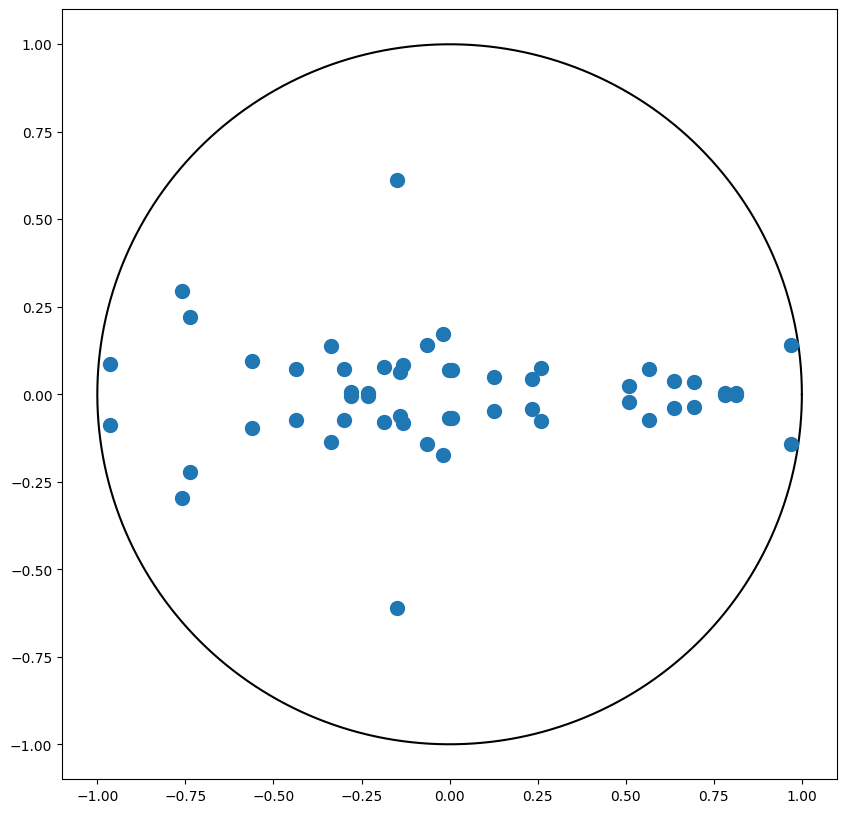

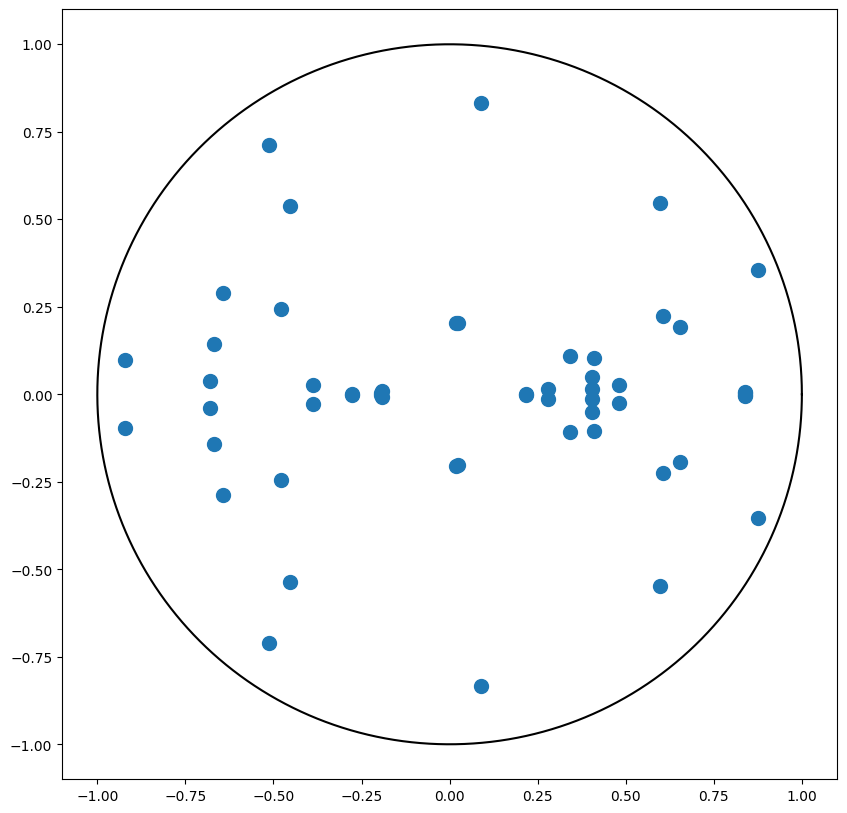

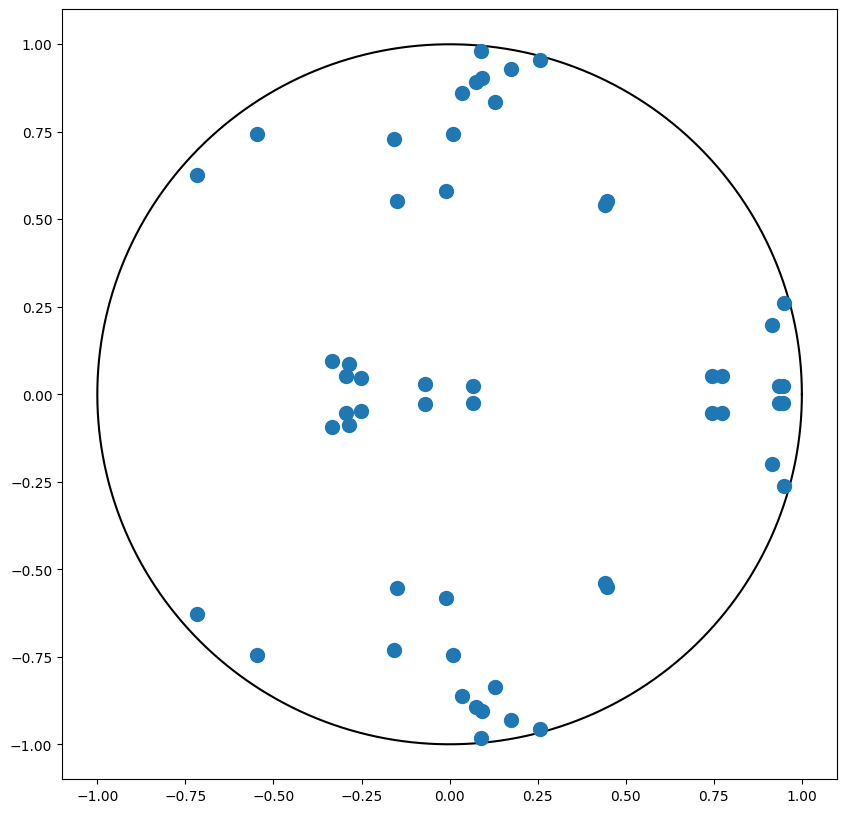

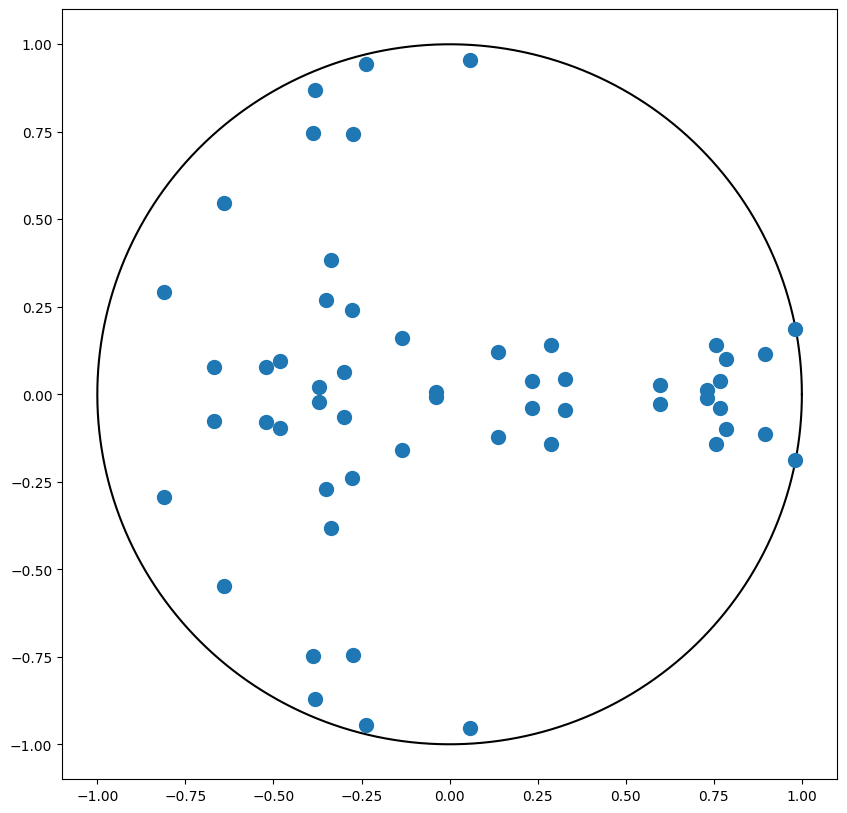

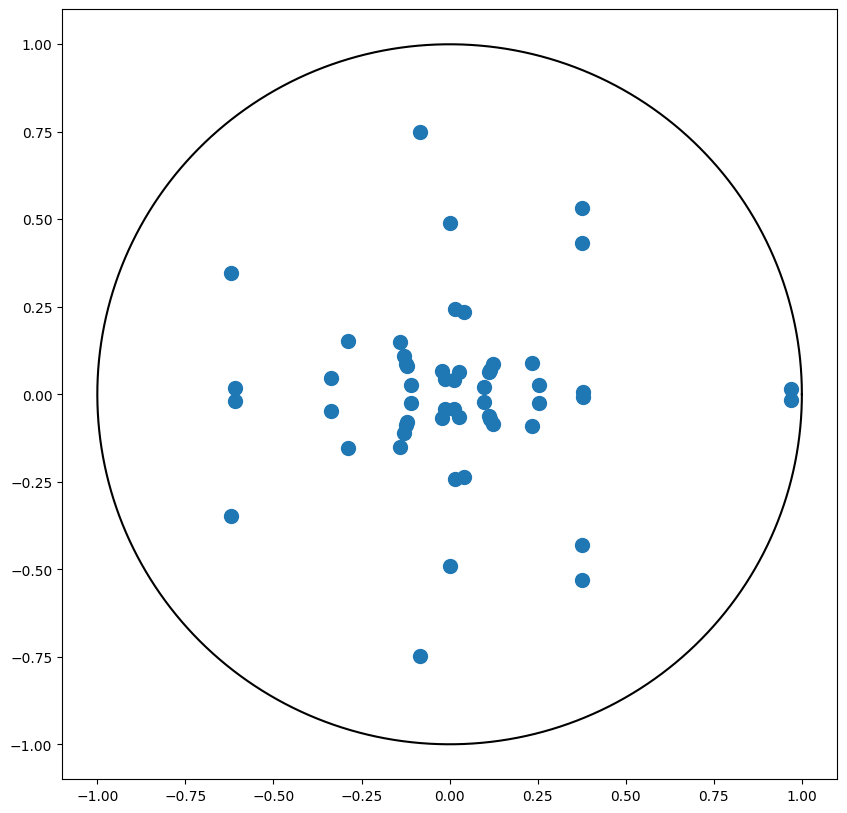

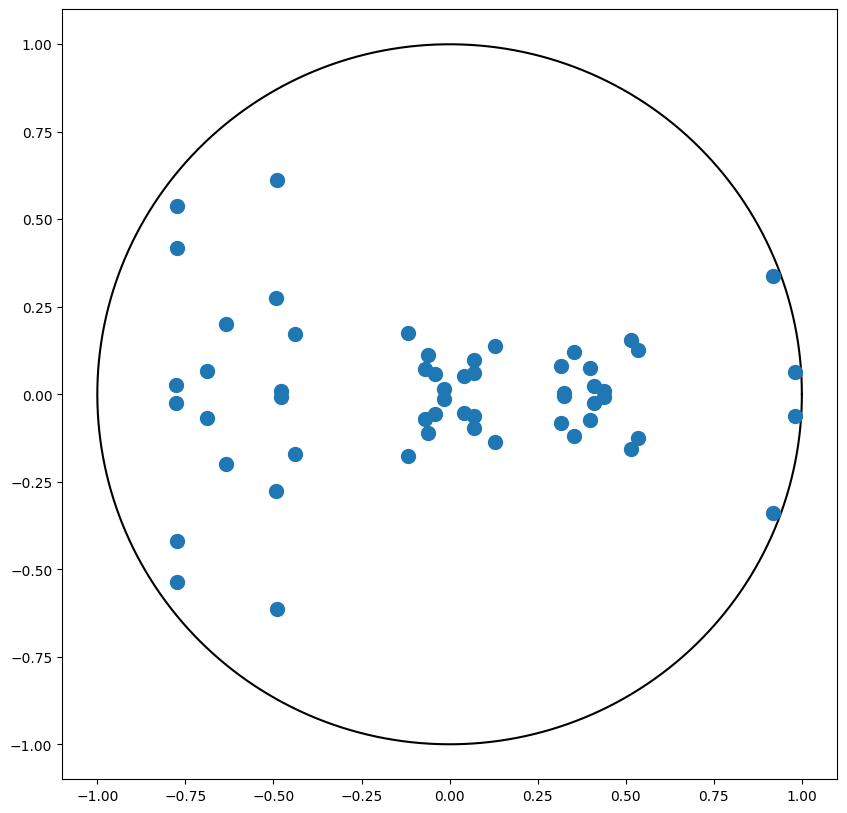

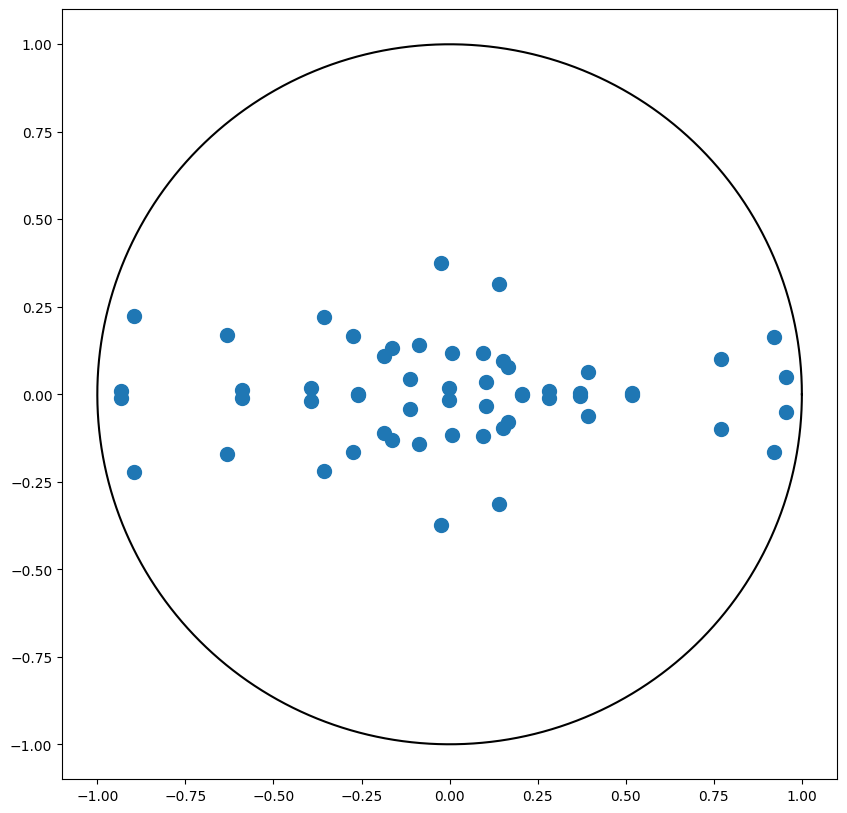

In [27]:
for csr in csr_list:
    csr.plot_circle()
    csr.plot()

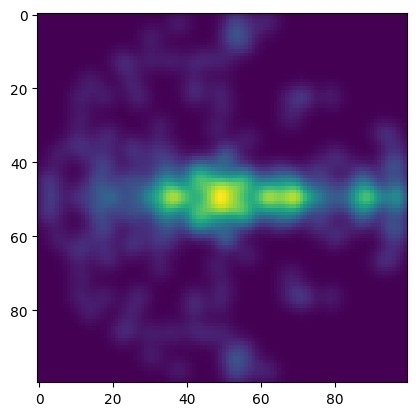

In [29]:
plt.imshow(csr_coat)
plt.show()